<a href="https://colab.research.google.com/github/viniciusrpb/cic0193_machinelearning/blob/main/cap2_2_feature_extraction_sift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 2

## 2.2. Extração de Características de Imagens utilizando Bag-of-Features (Bag-of-visual-words) com Scale Invariant Feature Transform (SIFT)

Vamos utilizar a coleção de imagens Swedish Leaf Dataset disponível aqui:

https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/

Particularmente, será utilizada a classe "1. Ulmus carpinifolia" e todas as 75 imagens foram convertidas de ".tif" para ".png" antes da execução desse notebook.


In [24]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

In [25]:
!cp -r "/content/drive/My Drive/leafs" "leafs"

Como a implementação do SIFT não está disponível na versão mais atual do opencv devido a uma patente, é preciso instalar uma versão mais antiga do opencv que tinha permissão para ter essa implementação

In [26]:
!pip3 install opencv-python==3.4.2.17
!pip3 install opencv-contrib-python==3.4.2.17

Importando as bibliotecas necessárias


In [27]:
import numpy as np
import cv2
import os
from os import listdir
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

Pega o nome dos arquivos associados às imagens das folhas

In [28]:
path_imgs = "leafs/leaf1/"

l_imgs = listdir(path_imgs)

## Implementação do Bag-of-Features

Primeiramente, deve-se inicializar uma lista relacionada a um dicionário, que vai armazenar os descritores de todos os "patches" (localidades) das imagens da entrada.

Em seguida, executa-se o SIFT, que retorna os keypoints (pontos locais) e o histograma das orientações para cada imagem da entrada. É importante salientar que cada imagem pode gerar um número diferentes de pontos-chave e o descritor sempre possui 128 posições.

Vale ressaltar que cada patch está associado com a região de um keypoint. Assim, o descritor de cada keypoint vai representar um vetor de características.

In [29]:
dictionary = []

for img_path in l_imgs:

  img = cv2.imread(path_imgs+img_path)

  sift = cv2.xfeatures2d.SIFT_create()

  keypoints,descriptor = sift.detectAndCompute(img,None)

  for d in descriptor:
    dictionary.append(d)

Resultado da detecção dos keypoints para uma imagem do conjunto das folhas

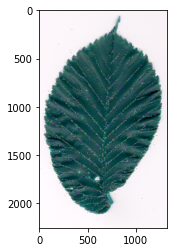

In [30]:
sample = cv2.imread('/content/leafs/leaf1/img1.png')

grays = cv2.cvtColor(sample,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

keypoints_img1,descriptor_img1 = sift.detectAndCompute(sample,None)

sample = cv2.drawKeypoints(sample,keypoints_img1,grays)
plt.imshow(sample)

A próxima etapa consiste na geração das "visual words" que serão os bins (posições) do histograma, isto é, representações dos grupos de K "patches".

No caso específico abaixo, utiliza-se o K-Means para gerar grupos nos vetores de características dos patches. Poderíamos utilizar qualquer outro algoritmo de agrupamento para esse propósito.

No caso abaixo, vamos gerar um histograma para a coleção de imagens com 50 "visual words". O resultado do K-Means é um modelo representado pelos centróides de cada agrupamento, isto é, as "visual words".

In [31]:
n_visual_words = 50

kmeans_model = KMeans(n_clusters=n_visual_words, 
                      verbose=False, 
                      init='random',
                      n_init=3)

clusters = kmeans_model.fit(dictionary)

Agora temos que gerar o histograma (hist_img) de cada imagem da entrada considerando apenas as "visual words" obtidas do K-Means.

Para isso, geramos novamente os patches para cada imagem da entrada e contabilizamos a frequência de cada patch no histograma da coleção de imagens (histogram). Observe que cada patch é representado pelo descritor SIFT de 128 posições. O histograma será normalizado em relação ao número de keypoints (pontos locais).

Para sabermos em qual bin do histograma que o patch será contabilizado, utilizamos um classificador baseado distância mínima para pegar a label do bin que o patch é mais similar.

In [32]:
histogram = []

for img_path in l_imgs:

  img = cv2.imread(path_imgs+img_path)

  keypoints, descriptor = sift.detectAndCompute(img,None)

  hist_img = np.zeros(n_visual_words)
  number_keypoints = np.size(keypoints)

  for d in descriptor:
    label = clusters.predict([d])
    hist_img[label] += 1/number_keypoints
  
  histogram.append(hist_img)

Por fim, geramos o DataFrame contendo os vetores de características da coleção de imagens da entrada

In [33]:
X = np.array(histogram)

attributes = []

for x in range(1,n_visual_words+1):
  attributes.append("attrib_"+str(x))

df = pd.DataFrame(X,columns=attributes)

Resultado final:

In [34]:
df

,attrib_1,attrib_2,attrib_3,attrib_4,attrib_5,attrib_6,attrib_7,attrib_8,attrib_9,attrib_10,attrib_11,attrib_12,attrib_13,attrib_14,attrib_15,attrib_16,attrib_17,attrib_18,attrib_19,attrib_20,attrib_21,attrib_22,attrib_23,attrib_24,attrib_25,attrib_26,attrib_27,attrib_28,attrib_29,attrib_30,attrib_31,attrib_32,attrib_33,attrib_34,attrib_35,attrib_36,attrib_37,attrib_38,attrib_39,attrib_40,attrib_41,attrib_42,attrib_43,attrib_44,attrib_45,attrib_46,attrib_47,attrib_48,attrib_49,attrib_50
0,0.009189,0.032029,0.014965,0.033342,0.024678,0.009451,0.014702,0.065897,0.011814,0.015752,0.016015,0.008139,0.008401,0.012602,0.024678,0.016540,0.017065,0.013652,0.032817,0.032292,0.006301,0.018903,0.008664,0.027041,0.012077,0.026254,0.037805,0.018640,0.019428,0.026779,0.007088,0.008401,0.013127,0.016277,0.022578,0.015752,0.008139,0.016277,0.018378,0.019428,0.015490,0.018378,0.012864,0.044894,0.035180,0.014439,0.007876,0.023891,0.055133,0.010501
1,0.007027,0.034024,0.024408,0.041050,0.036982,0.009246,0.006287,0.066568,0.012944,0.018121,0.013314,0.008506,0.005917,0.012944,0.026627,0.012574,0.019970,0.016272,0.023669,0.038831,0.007396,0.029956,0.005917,0.036982,0.012574,0.039201,0.032175,0.012574,0.024038,0.018491,0.007027,0.009615,0.011834,0.011095,0.012574,0.022929,0.007396,0.013314,0.013314,0.015902,0.015902,0.011095,0.013683,0.033284,0.041790,0.021820,0.008876,0.019601,0.045118,0.009246
2,0.005714,0.023673,0.018776,0.045714,0.050612,0.007347,0.008163,0.067755,0.021224,0.038367,0.011429,0.017959,0.021224,0.012245,0.013061,0.014694,0.020408,0.017959,0.006531,0.031020,0.016327,0.017143,0.004898,0.053878,0.017959,0.052245,0.011429,0.004898,0.007347,0.000816,0.014694,0.003265,0.026122,0.007347,0.004082,0.021224,0.008980,0.006531,0.007347,0.013878,0.028571,0.022041,0.013878,0.013061,0.058776,0.026122,0.009796,0.021224,0.039184,0.013061
3,0.013453,0.025112,0.021749,0.034081,0.025785,0.014574,0.026682,0.045740,0.013453,0.018161,0.020404,0.010314,0.006502,0.017713,0.024215,0.016592,0.013901,0.020404,0.010314,0.033632,0.013004,0.030045,0.019507,0.025785,0.009417,0.029372,0.026906,0.016143,0.027130,0.017713,0.011883,0.011659,0.013677,0.023543,0.024664,0.021076,0.008969,0.015247,0.018161,0.022646,0.018834,0.016143,0.013229,0.024215,0.035426,0.011883,0.008744,0.028924,0.032287,0.010987
4,0.007220,0.018051,0.010229,0.032491,0.093863,0.003610,0.012034,0.067389,0.023466,0.011432,0.008424,0.013237,0.010830,0.015644,0.010830,0.012635,0.015644,0.010830,0.043321,0.018652,0.003008,0.014440,0.003008,0.043321,0.012635,0.083634,0.022864,0.007822,0.004813,0.019856,0.012635,0.007822,0.014440,0.011432,0.015042,0.032491,0.005415,0.015644,0.002407,0.011432,0.020457,0.016847,0.009627,0.028279,0.035499,0.020457,0.009627,0.015042,0.054152,0.006017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.011583,0.032336,0.011583,0.045367,0.043919,0.005792,0.016409,0.102799,0.016409,0.023649,0.010618,0.011583,0.012066,0.013514,0.014961,0.014961,0.014479,0.007722,0.018822,0.036680,0.010135,0.020270,0.003861,0.037645,0.016409,0.047297,0.018340,0.006757,0.009170,0.009170,0.013031,0.003378,0.018340,0.011100,0.008687,0.016409,0.009653,0.009170,0.010618,0.012548,0.018340,0.020270,0.015927,0.019788,0.037162,0.022683,0.013996,0.015444,0.069015,0.010135
71,0.009026,0.031593,0.005158,0.040619,0.069632,0.003224,0.010961,0.104449,0.010316,0.018698,0.011605,0.012250,0.013540,0.011605,0.014184,0.011605,0.013540,0.003868,0.000645,0.031593,0.008382,0.013540,0.003868,0.032237,0.019987,0.090909,0.020632,0.005803,0.003224,0.005803,0.010961,0.005158,0.018053,0.010961,0.014829,0.036750,0.007092,0.003868,0.000645,0.009671,0.025790,0.019342,0.012895,0.037395,0.030948,0.017408,0.012250,0.018698,0.068988,0.005803
72,0.011089,0.039604,0.009901,0.047129,0.037624,0.005545,0.010693,0.060594,0.010297,0.019010,0.007525,0.012673,0.009505,0.013069,0.032871,